In [1]:
import sys
sys.path.append('..')
import config
from autoencoding import AutoEncoder

Using Theano backend.


In [2]:
import os
model_path = config.MODEL_PATH
model = AutoEncoder.from_h5(model_path)

../autoencoding.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/dense_1_i..., outputs=sigmoid.0)`
  output=model.layers[idx_code_layer].output)


In [3]:
train_dir = config.TRAIN_DIR
files = [os.path.join(train_dir, f) for f in os.listdir(train_dir)][:15000]

In [4]:
import numpy as np
kvps = [(os.path.basename(f).rpartition('-')[0], np.load(f) * 2000) for f in files]

In [5]:
kvps[:10]

[('Wall of Voodoo-Call of the West-They Dont Want Me.mp3 ',
  array([  1.37899292e+02,   2.62356208e+02,   4.26610339e+02,
           6.21462488e+02,   8.36143311e+02,   1.05899861e+03,
           1.27821735e+03,   1.48255088e+03,   1.66197332e+03,
           1.80823914e+03,   1.91530224e+03,   1.97957269e+03,
           2.00000000e+03,   1.97798496e+03,   1.91713499e+03,
           1.82288887e+03,   1.70204501e+03,   1.56223323e+03,
           1.41137158e+03,   1.25714861e+03,   1.10656682e+03,
           9.65575973e+02,   8.38815643e+02,   7.29476725e+02,
           6.39281159e+02,   5.68569912e+02,   5.16481336e+02,
           4.81196242e+02,   4.60222762e+02,   4.50693276e+02,
           4.49647434e+02,   4.54279147e+02,   4.62130892e+02,
           4.71225128e+02,   4.80129466e+02,   4.87958683e+02,
           4.94322279e+02,   4.99230496e+02,   5.02974295e+02,
           5.05995601e+02,   5.08763273e+02,   5.11667882e+02,
           5.14944941e+02,   5.18632099e+02,   5.22561483e

# Look at how well autoencoder predicts input

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_test_input(kvps, k=5):
    sample = random.sample(kvps, k=k)
    labels = [f for f, x in sample]
    arrays = [x.reshape((1, x.shape[0])) for f, x in sample]
    return labels, arrays

def compare_predictions(test_input, model, labels):
    plt.figure(figsize=(30, 30))
    f, axarr = plt.subplots(len(test_input), sharex=True, sharey=True)
    f.subplots_adjust(hspace=.5)
    for i, (X, L) in enumerate(zip(test_input, labels)):
        xshape = X.shape[1]
        y_hat = model.predict(X)
        axarr[i].plot(X.reshape((xshape,)))
        axarr[i].plot(y_hat.reshape((xshape,)), color='r')
        axarr[i].set_title(L, fontsize=8)

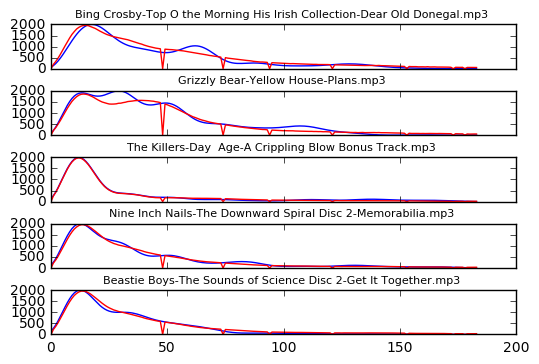

In [7]:
test_files, test_input = get_test_input(kvps)
compare_predictions(test_input, model, [os.path.basename(f) for f in test_files])

# Evaluate search

In [8]:
import numpy as np

def init_db(encoder, kvps, feature_size):
    labels = [L for L, x in kvps]
    features = [x for L, x in kvps]
    codes = encoder(np.array(features))
    db = [(f, code) for f, code in zip(files, codes)]
    return db

def linear_search(db, q, score_func):
    scores = [(k, score_func(q, v)) for k, v in db]
    return sorted(scores, key=lambda x: x[1], reverse=True)

def cosine_distance(x1, x2):
    return x1.dot(x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [9]:
%%time
db = init_db(model.encode, kvps, 184)

CPU times: user 5.32 s, sys: 1.28 s, total: 6.6 s
Wall time: 1.94 s


In [10]:
test = random.choice(files)
test

'../data/preprocessed/The Jimi Hendrix Experience-Axis Bold As Love-Bold As Love.mp3 - 4 sec.npy'

In [11]:
q = np.load(test) * 2000
q = model.encode(q.reshape((1, q.shape[0]))).transpose().reshape((32,))
print(q.shape)
q

(32,)


array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0])

In [12]:
%%time
linear_search(db, q, cosine_distance)

CPU times: user 680 ms, sys: 0 ns, total: 680 ms
Wall time: 666 ms


[('../data/preprocessed/Grizzly Bear-Friend EP-Knife Coverd By CSS.mp3 - 79 sec.npy',
  1.0),
 ('../data/preprocessed/Nine Inch Nails-The Downward Spiral Disc 1-Hurt.mp3 - 31 sec.npy',
  1.0),
 ('../data/preprocessed/Metallica-Reload-Fixxxer.mp3 - 214 sec.npy', 1.0),
 ('../data/preprocessed/Cool Hand Luke-The Balancing Act-A Floating Smile.mp3 - 15 sec.npy',
  1.0),
 ('../data/preprocessed/Neil Young-Mirror Ball-Big Green Country.mp3 - 80 sec.npy',
  1.0),
 ('../data/preprocessed/Alice In Chains-Greatest Hits-Would.mp3 - 134 sec.npy',
  1.0),
 ('../data/preprocessed/Pearl jam  1994  Vitalogy-Vitalogy-Whipping.mp3 - 94 sec.npy',
  1.0),
 ('../data/preprocessed/Incubus-A Crow Left Of The Murder-Here In My Room.mp3 - 123 sec.npy',
  1.0),
 ('../data/preprocessed/Stevan Pasero-Guitar Masterpieces-Carmen Habanera.mp3 - 133 sec.npy',
  1.0),
 ('../data/preprocessed/Santana-Supernatural-El Farol.mp3 - 194 sec.npy', 1.0),
 ('../data/preprocessed/Cars-Complete Greatest Hits-Shake It Up.mp3 - 66

# Look at distribution of codes. Are they binary?

In [13]:
db[:100]

[('../data/preprocessed/Wall of Voodoo-Call of the West-They Dont Want Me.mp3 - 119 sec.npy',
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1])),
 ('../data/preprocessed/King Crimson-In The Court Of The Crimson King-Moon Child.mp3 - 99 sec.npy',
  array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 1, 0])),
 ('../data/preprocessed/A Tribe Called Quest-Midnight Marauders-Hot Sex.mp3 - 48 sec.npy',
  array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1])),
 ('../data/preprocessed/Paul Revere  the Raiders-Greatest Hits-Action .mp3 - 62 sec.npy',
  array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0])),
 ('../data/preprocessed/Duke EllingtonElla Fitzgerald-Ella  Duke at the Côte DAzur Disc 1-Jive Jam.mp3 - 351 sec.npy',
  array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1,

In [14]:
from collections import Counter
from itertools import chain

In [15]:
c = Counter([round(c, 2) for file, code in db for c in code])

(array([ 329146.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,  150854.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 30 Patch objects>)

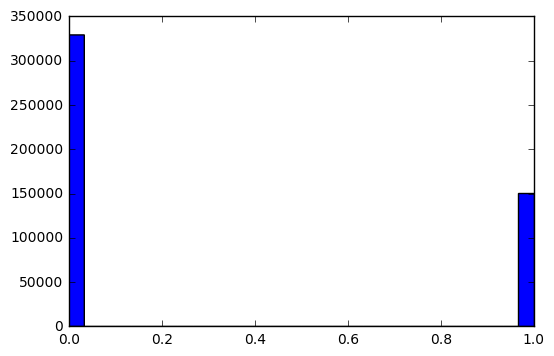

In [16]:
plt.hist([round(c, 2) for _, code in db for c in code], bins=30)

# Semantic hashing

In [17]:
y = np.array([[2**i for i in range(32)]])
y.shape

(1, 32)

In [18]:
X = np.array([c for _, c in db])
X.shape

(15000, 32)

In [19]:
keys = X.dot(y.transpose())

In [20]:
Counter(kk for k  in keys for kk in k).most_common()

[(3229876290, 986),
 (3246656066, 847),
 (3246655554, 546),
 (1103137540, 488),
 (1099172612, 446),
 (3229876802, 404),
 (3246656326, 363),
 (3246656256, 337),
 (1103141636, 250),
 (1099209476, 229),
 (3313764352, 222),
 (3246656000, 217),
 (3246656320, 206),
 (1099176708, 201),
 (3229877058, 196),
 (3246660352, 180),
 (3246656260, 177),
 (1105304324, 162),
 (3313764864, 159),
 (3229878338, 153),
 (1103207172, 152),
 (1367645060, 137),
 (1099172676, 136),
 (1099209604, 127),
 (3246656064, 127),
 (3246656322, 124),
 (1371839364, 120),
 (3313768960, 111),
 (1105238788, 108),
 (1103403780, 107),
 (1103104836, 105),
 (3313768448, 98),
 (3296987136, 95),
 (1103104772, 93),
 (1906112694, 86),
 (1099172678, 85),
 (1099176836, 80),
 (1103104838, 79),
 (3246656070, 77),
 (3583776896, 74),
 (3246656324, 73),
 (3246655488, 72),
 (3582204416, 70),
 (3246660096, 70),
 (1103403908, 68),
 (1103366982, 63),
 (3582203904, 63),
 (3246655490, 61),
 (3582728320, 61),
 (3246660356, 61),
 (3246659584, 60),


In [21]:
class SemanticHashTable:
    def __init__(self, keys, values, encoder):
        self._vint = np.array([2**i for i in range(encoder.code_length)])
        keys = self._int(keys)
        self._kvps = collections.defaultdict()
        for k, v in zip(keys, values):
            self._kvps[k].append(v)

    def _int(self, keys):
        X = np.array(keys)
        return X.dot(self._vint.transpose())

    def query(self, q):
        key = encoder.encode(q).dot(self._vint.transpose())[0]
        idx = self._retrieve_from(key)
        return list(itertools.chain(self._kvps[i] for i in idx))

    @classmethod
    def _retrieve_from(cls, n):
        indices = []
        for x in range(n):
            hd = cls._hamming_distance(n, x)
            if hd >= 6:
                indices.append(x)
        return indices

    @staticmethod
    def _hamming_distance(n1, n2):
        mx = max(n1, n2)
        bit = 0
        hd = 0
        while bit < mx:
            bit <<= 1
            if bit & n1 & n2:
                matches += 1
        return hd

In [22]:
keys = [k for k, v in db]
vals = [v for k, v in db]
sht = SemanticHashTable(keys, vals, model)

ValueError: shapes (15000,) and (32,) not aligned: 15000 (dim 0) != 32 (dim 0)